# Introduction
The purpose of the following report is to answer the following questions: 
- What are the most valuable (£/tonne) kinds of fish landed in English ports?  
- What are the fishing vassels that operate in those ports? What features or characteristics do they have and how do those compare to vessels in other ports? 

Your target audience would be an organization related to the UK fishing industry in relation to fishermen's welfare or conservation of fish stocks. The report should ask and answer two questions based on the data set provided. 

The data analyzed are from :
 - vessels-all.csv - https://www.gov.uk/government/collections/uk-vessel-lists 
 - landings-all.csv - https://www.gov.uk/government/collections/monthly-uk-sea-fisheries-statistics 

We will use data analysis, and the tools it provides, such as statistical calculations and graphs in order to answer the questions posed.



In [1]:
import pandas, glob, os, numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

# Normalising the data

In [2]:
landings_df = pandas.DataFrame()
for file in glob.glob('data/FishLandings/*'):
    df = pandas.read_csv(file, encoding="ISO-8859-1")
    landings_df = landings_df.append(df)

In [3]:
landings_df['Vessel Nationality'].unique()

array(['UK - Wales', 'UK - Scotland', 'UK - England',
       'UK - Northern Ireland', 'Ireland', 'UK - Guernsey',
       'UK - Isle of Man', 'UK - Jersey', 'Denmark', 'France', 'Norway',
       'Sweden', 'Spain', 'Belgium', 'Netherlands', 'Germany',
       'Faeroe Islands'], dtype=object)

In [4]:
# UK vessel's landings
UK_NATIONALITIES = ['UK - Wales', 'UK - Scotland', 'UK - England',
       'UK - Northern Ireland', 'Ireland', 'UK - Guernsey',
       'UK - Isle of Man', 'UK - Jersey']
landings_df = landings_df[landings_df['Vessel Nationality'].isin(UK_NATIONALITIES)]

In [5]:
vessels_df = pandas.DataFrame()
for file in glob.glob('data/FishingVessels/*'):
    df = pandas.read_excel(file, skiprows=4)
    df.rename(columns={
        "Engine Power (kw)": "Engine power",
        "Hull": "Hull Material",
        "Port letters and number": "Port letters and numbers",
        "Scallop Licence (Y/N)": "Scallop licence",
        "Scallop licence (Y/N)": "Scallop licence",
        "Shellfish Licence  licence (Y/N)": "Shellfish licence",
        "Shellfish  licence (Y/N)": "Shellfish licence",
        "Vessel Capacity Units": "Vessel capacity units",
        "Year Built": "Year built",
        "Country of Build": "Country of construction"
        
    }, inplace=True)
    df['Year'] = int(os.path.basename(file).split('_')[1])
    vessels_df = vessels_df.append(df)

In [6]:
vessels_df['identifier'] = vessels_df['Registry of Shipping and Seamen number'] + vessels_df['Port letters and numbers']
vessels_df['Home port'] = vessels_df['Home port'].str.capitalize()

In [7]:
vessels_df.drop_duplicates('identifier', inplace=True)

# Analysing the data

## Obtaining the mean ship age

This will later be used as the benchmark number to see whether ports with newer ships result in more profitable landings

In [8]:
vessels_df['Year built'].mean()

1991.598025816249

## Means table for ports

In [9]:
#vessels_df.groupby('Home port')[['Year built', 'Registered tonnage', 'Overall length']].mean()
vessels = vessels_df.groupby('Home port').agg(
    vessel_count=('Home port', 'size'), 
    mean_year=('Year built', 'mean'),
    mean_tonnage=('Registered tonnage', 'mean'),
    total_tonnage=('Registered tonnage', 'sum'),
    mean_length=('Overall length', 'mean'),
)
vessels['age'] = 2022 - vessels['mean_year']
vessels['modern_vessel'] = numpy.where(vessels['age']<vessels['age'].mean(), 'Y', 'N')
vessels.head()

,vessel_count,mean_year,mean_tonnage,total_tonnage,mean_length,age,modern_vessel
Home port,,,,,,,
Aberaeron,3,2006.000000,1.326667,3.98,6.363333,16.000000,Y
Aberdaran,6,1999.500000,1.341667,8.05,6.108333,22.500000,Y
Aberdeen,42,1998.536585,3.222381,135.34,6.990000,23.463415,Y
Aberdovey,9,1985.625000,4.072222,36.65,7.947778,36.375000,N
Abersoch,7,1982.333333,3.512857,24.59,7.472857,39.666667,N


In [10]:
landings_by_port = landings_df.groupby('Port of Landing').agg(
    landing_count=('Port of Landing', 'size'), 
    mean_value=('Value(£)', 'mean'),
    total_value=('Value(£)', 'sum'),
    mean_weight=('Landed Weight (tonnes)', 'mean'),
    total_weight=('Landed Weight (tonnes)', 'sum'),
)
landings_by_port['value_per_tonne'] = landings_by_port['total_value'] / landings_by_port['total_weight']
landings_by_port.head()

,landing_count,mean_value,total_value,mean_weight,total_weight,value_per_tonne
Port of Landing,,,,,,
Aalborg,7,224.510000,1571.57,0.076429,0.5350,2937.514019
Abbotsbury,29,523.071724,15169.08,0.188438,5.4647,2775.830329
Aberaeron,16,399.975625,6399.61,0.076088,1.2174,5256.784952
Aberdaran,129,5195.255659,670187.98,0.695226,89.6842,7472.754175
Aberdeen,299,10670.623077,3190516.30,4.071241,1217.3011,2620.975451


## Means table for species

In [11]:
landings_by_species = landings_df.groupby('Species Name').agg(
    landing_count=('Port of Landing', 'size'), 
    mean_value=('Value(£)', 'mean'),
    total_value=('Value(£)', 'sum'),
    mean_weight=('Landed Weight (tonnes)', 'mean'),
    total_weight=('Landed Weight (tonnes)', 'sum'),
)
landings_by_species['value_per_tonne'] = landings_by_species['total_value'] / landings_by_species['total_weight']
landings_by_species.head()

,landing_count,mean_value,total_value,mean_weight,total_weight,value_per_tonne
Species Name,,,,,,
Albacore,21,118.022857,2478.48,0.334614,7.0269,352.713145
Anchovy,168,7162.327440,1203271.01,7.903636,1327.8109,906.206607
Angel Shark,7,0.000000,0.00,0.030986,0.2169,0.000000
Arctic Skate,73,110.011507,8030.84,0.103030,7.5212,1067.760464
Argentine Hake (Sw Atlantic),16,42776.455625,684423.29,21.140431,338.2469,2023.442905


In [12]:
landings_by_species_group = landings_df.groupby('Species as shown in publication').agg(
    landing_count=('Port of Landing', 'size'), 
    mean_value=('Value(£)', 'mean'),
    total_value=('Value(£)', 'sum'),
    mean_weight=('Landed Weight (tonnes)', 'mean'),
    total_weight=('Landed Weight (tonnes)', 'sum'),
)
landings_by_species_group['value_per_tonne'] = landings_by_species_group['total_value'] / landings_by_species_group['total_weight']
landings_by_species_group.head()

,landing_count,mean_value,total_value,mean_weight,total_weight,value_per_tonne
Species as shown in publication,,,,,,
Bass,8153,2192.612295,17876368.04,0.224422,1829.7125,9770.042037
Blue Whiting,73,668982.946027,48835755.06,3270.289767,238731.1530,204.563814
Brill,7637,1402.398748,10710119.24,0.219389,1675.4739,6392.292497
Catfish,1056,3888.993693,4106777.34,1.796855,1897.4790,2164.333487
Cockles,300,80138.318667,24041495.60,92.315730,27694.7191,868.089527


## Combined means table

In [13]:
port_data = pandas.concat([vessels, landings_by_port], axis=1, join='inner')
port_data.head()

,vessel_count,mean_year,mean_tonnage,total_tonnage,mean_length,age,modern_vessel,landing_count,mean_value,total_value,mean_weight,total_weight,value_per_tonne
Aberaeron,3,2006.000000,1.326667,3.98,6.363333,16.000000,Y,16,399.975625,6399.61,0.076088,1.2174,5256.784952
Aberdaran,6,1999.500000,1.341667,8.05,6.108333,22.500000,Y,129,5195.255659,670187.98,0.695226,89.6842,7472.754175
Aberdeen,42,1998.536585,3.222381,135.34,6.990000,23.463415,Y,299,10670.623077,3190516.30,4.071241,1217.3011,2620.975451
Aberdovey,9,1985.625000,4.072222,36.65,7.947778,36.375000,N,172,1606.694012,276351.37,0.184103,31.6657,8727.151776
Abersoch,7,1982.333333,3.512857,24.59,7.472857,39.666667,N,66,3320.652879,219163.09,0.303639,20.0402,10936.172793


# Bar chart for the most valuable species groups and how they compare against the most often caught ones

In [14]:
top_5_species_by_value = landings_by_species_group.sort_values(by='value_per_tonne', ascending=False).head(5)
top_5_speices_by_weight = landings_by_species_group.sort_values(by='total_weight', ascending=False).head(5)
top_weight_and_values =  pandas.concat([
    top_5_species_by_value,
    top_5_speices_by_weight
])
top_weight_and_values

,landing_count,mean_value,total_value,mean_weight,total_weight,value_per_tonne
Species as shown in publication,,,,,,
Lobsters,23406,7511.522496,1.758147e+08,0.560292,13114.1914,13406.445748
Sole,10827,6852.213843,7.418892e+07,0.665483,7205.1795,10296.609443
Bass,8153,2192.612295,1.787637e+07,0.224422,1829.7125,9770.042037
Turbot,8436,3411.532508,2.877969e+07,0.369121,3113.9029,9242.320382
Halibut,1786,3334.355633,5.955159e+06,0.431088,769.9228,7734.748419
Mackerel,6446,122476.480679,7.894834e+08,124.568578,802969.0507,983.205260
Herring,1848,96569.702917,1.784608e+08,194.183819,358851.6980,497.310761
Blue Whiting,73,668982.946027,4.883576e+07,3270.289767,238731.1530,204.563814
Crabs,35968,7676.359373,2.761033e+08,3.874968,139374.8647,1981.012104


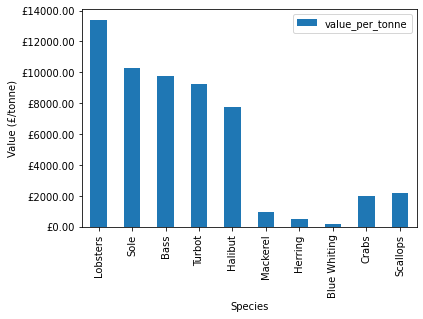

In [15]:
plot = top_weight_and_values.plot(kind='bar', y='value_per_tonne', xlabel=None)
plot.set_xlabel("Species")
plot.set_ylabel("Value (£/tonne)")
plot.yaxis.set_major_formatter('£{x:1.2f}')

As shown by the graph, lobster is the most valuable type of fish, on average valued at £13,406 per tonne, being 13 times more expensive than the most captured fish (Mackerel). It is followed by Sole (10296.60) and Bass (£9770.04).

# Ports that caught the most amount of high value fish

In [16]:
# valuable_landings_df
valuable_landings_df = landings_df[landings_df['Species as shown in publication'].isin(top_5_species_by_value.index)]
top_valuable_landings_ports = valuable_landings_df.groupby('Port of Landing').sum().sort_values(by='Landed Weight (tonnes)', ascending=False).head(10)
top_valuable_landings_ports[['Live Weight (tonnes)', 'Landed Weight (tonnes)', 'Value(£)']]

,Live Weight (tonnes),Landed Weight (tonnes),Value(£)
Port of Landing,,,
Brixham,3075.1226,2925.9467,3.531426e+07
Newlyn,1645.8788,1574.5438,1.806962e+07
Harlingen,1650.0641,1545.4757,1.270062e+07
Bridlington,1475.2990,1475.2986,1.999088e+07
Scarborough,601.5844,597.5420,8.190250e+06
Plymouth,591.3802,571.6661,6.824405e+06
Peterhead,560.7886,519.8045,4.412229e+06
Arbroath,464.6588,464.6588,6.690730e+06
Whitby,460.9316,460.7790,6.351156e+06


In [17]:
import geopy, json

geocoder = geopy.Nominatim(user_agent="tm351-geocoding")
CACHE_FILE = 'location_cache.json'
def geocode(location):
    locations = {}
    if os.path.exists(CACHE_FILE):
        with open(CACHE_FILE, 'r') as f: 
            locations = json.loads(f.read())

    if location not in locations: 
        geo = geocoder.geocode(location, country_codes=['gb','ie'])        
        locations[location] = {"latitude": geo.latitude, "longitude": geo.longitude} if geo else {}
        
        with open(CACHE_FILE, 'w') as f: 
            f.write(json.dumps(locations))
            
    return locations[location]

In [18]:
import folium

osmap = folium.Map(location=[55.509865, -0.11], zoom_start=5,height=500,width=800)
for index, port in top_valuable_landings_ports.iterrows():
    geo = geocode(index)
    if geo:
        folium.Marker([geo['latitude'], geo['longitude']], popup=index).add_to(osmap)

osmap

## Are those simply the largest ports ?

In [19]:
# Add rank to port based on total weight landed there
landings_by_port['total_weight_rank'] = landings_by_port['total_weight'].rank(ascending=False)
# landings_by_port[landings_by_port['']]
landings_by_port[landings_by_port.index.isin(top_valuable_landings_ports.index)][['total_weight_rank']]
# landings_by_port['total_weight'].rank(method='max')

,total_weight_rank
Port of Landing,
Arbroath,113.0
Bridlington,31.0
Brixham,13.0
Harlingen,15.0
Newlyn,14.0
Peterhead,1.0
Plymouth,18.0
Scarborough,45.0
Weymouth,54.0


### Pie chart showing the proportion of fish caught at those ports

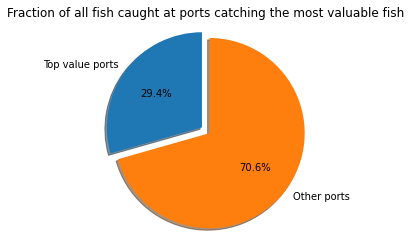

In [20]:
tonnes_landed_there = landings_by_port[landings_by_port.index.isin(top_valuable_landings_ports.index)]['total_weight'].sum()
tonnes_landed_elsewhere = landings_by_port[~landings_by_port.index.isin(top_valuable_landings_ports.index)]['total_weight'].sum()

labels = 'Top value ports', 'Other ports'
sizes = [tonnes_landed_there, tonnes_landed_elsewhere]
explode = (0.1, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.title("Fraction of all fish caught at ports catching the most valuable fish")
plt.show()

### Pie chart showing th proportion of valuable fish caught there 

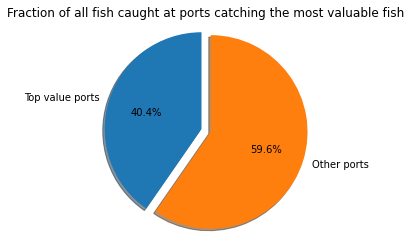

In [21]:
tonnes_landed_there = valuable_landings_df[valuable_landings_df['Port of Landing'].isin(top_valuable_landings_ports.index)]['Landed Weight (tonnes)'].sum()
tonnes_landed_elsewhere = valuable_landings_df[~valuable_landings_df['Port of Landing'].isin(top_valuable_landings_ports.index)]['Landed Weight (tonnes)'].sum()


labels = 'Top value ports', 'Other ports'
sizes = [tonnes_landed_there, tonnes_landed_elsewhere]
explode = (0.1, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.title("Fraction of all fish caught at ports catching the most valuable fish")
plt.show()

## Are the ships at those ports more modern? 

In [93]:
vessels_df['at_top_port'] = numpy.where(vessels_df['Home port'].isin(top_valuable_landings_ports.index), 'Y', 'N')
vessels_df['age'] = 2022 - vessels_df['Year built']
vessels_at_top_ports = vessels_df[vessels_df['at_top_port']=='Y']
vessels_outside_top_ports = vessels_df[vessels_df['at_top_port']=='N']

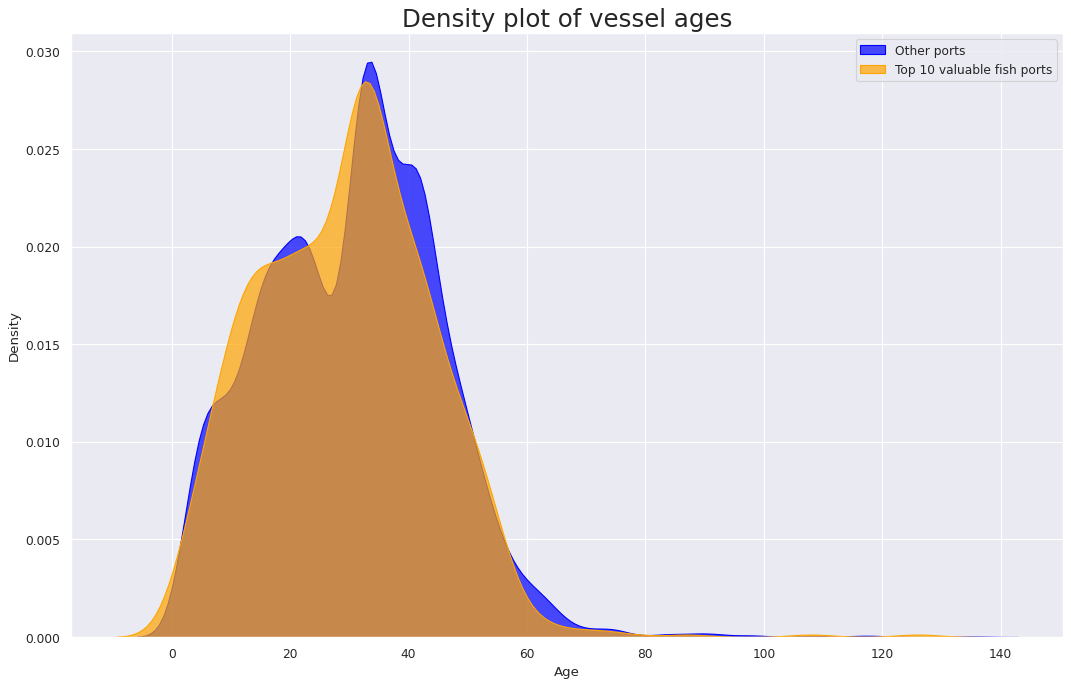

In [98]:
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(vessels_outside_top_ports['age'], shade=True, color="blue", label="Other ports", alpha=.7)
sns.kdeplot(vessels_at_top_ports['age'], shade=True, color="orange", label="Top 10 valuable fish ports", alpha=.7)

plt.title('Density plot of vessel ages', fontsize=22)
plt.xlabel('Age')
plt.legend()
plt.show()

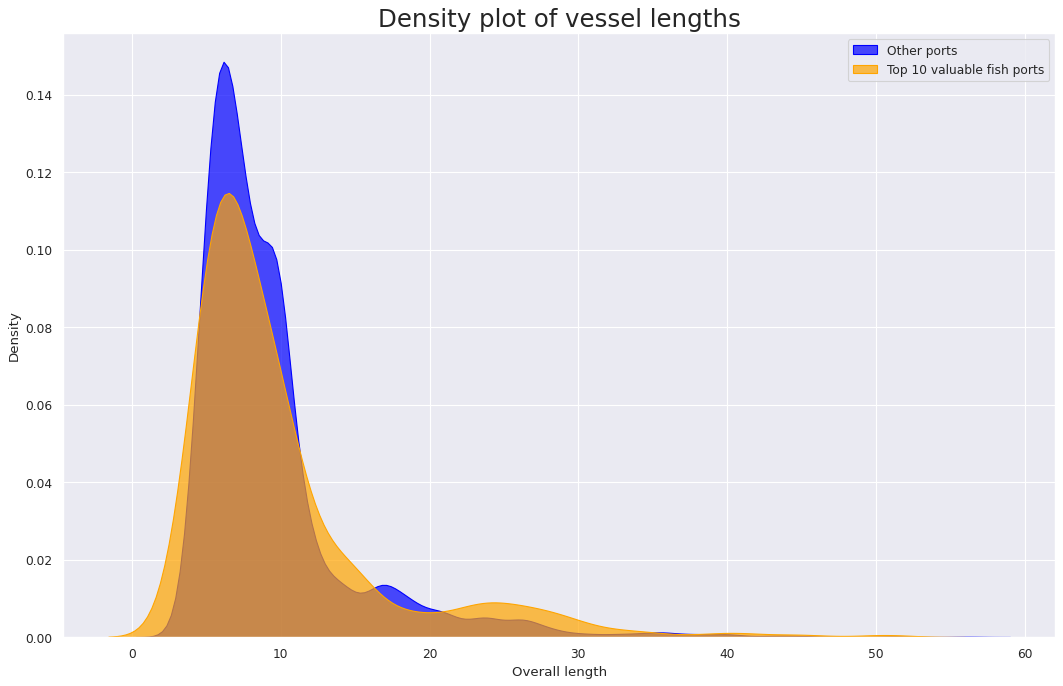

In [118]:
outside_vessel_lenghts = vessels_outside_top_ports[vessels_outside_top_ports['Overall length']<60]
top_vessel_lenghts = vessels_at_top_ports[vessels_at_top_ports['Overall length']<60]

plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(outside_vessel_lenghts['Overall length'], shade=True, color="blue", label="Other ports", alpha=.7)
sns.kdeplot(top_vessel_lenghts['Overall length'], shade=True, color="orange", label="Top 10 valuable fish ports", alpha=.7)

plt.title('Density plot of vessel lengths', fontsize=22)
plt.xlabel('Overall length')
plt.legend()
plt.show()

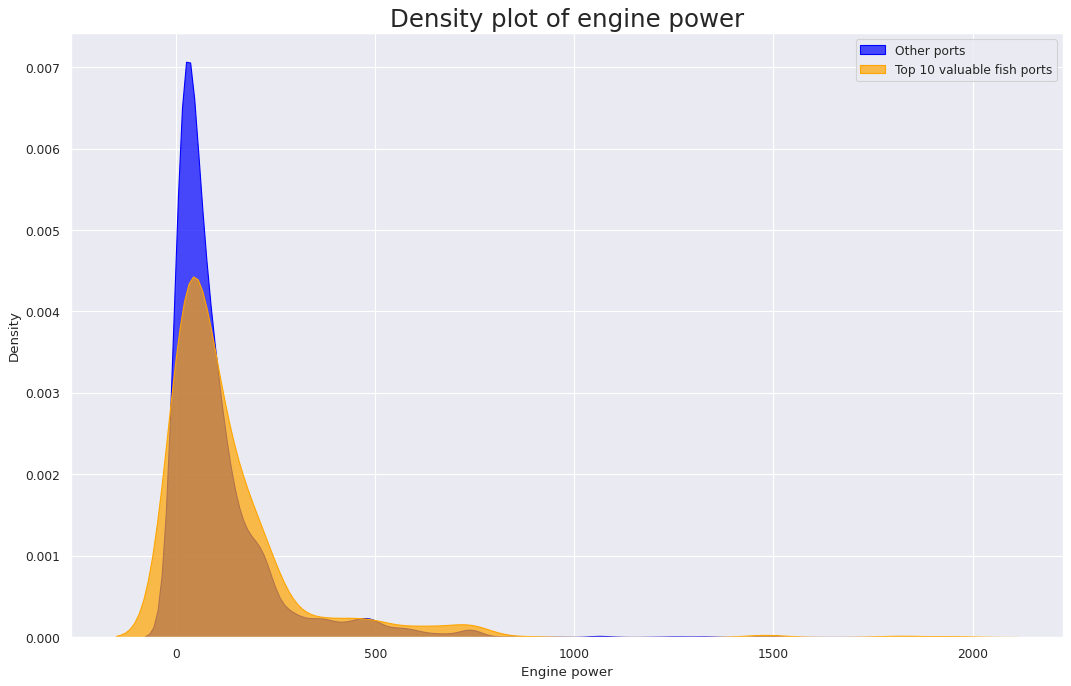

In [134]:
outside_vessel_lenghts = vessels_outside_top_ports[vessels_outside_top_ports['Engine power']<2000]
top_vessel_lenghts = vessels_at_top_ports[vessels_at_top_ports['Engine power']<2000]

plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(outside_vessel_lenghts['Engine power'], shade=True, color="blue", label="Other ports", alpha=.7)
sns.kdeplot(top_vessel_lenghts['Engine power'], shade=True, color="orange", label="Top 10 valuable fish ports", alpha=.7)

plt.title('Density plot of engine power', fontsize=22)
plt.xlabel('Engine power')
plt.legend()
plt.show()

## kNN to to classify whether a ship belongs to one of those ports

In [22]:
import numpy as np
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

In [60]:
TRAINING_COLUMNS = ['Overall length', 'Registered tonnage', 'Engine power', 'Vessel capacity units', 'Year built']
TRAINING_COLUMNS_OTHER = ['Hull Material', 'Shellfish licence', 'Scallop licence']

training_data = vessels_df[TRAINING_COLUMNS + ['at_top_port']].dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
trainingData_df = training_data[TRAINING_COLUMNS]
targetData_df = training_data['at_top_port']

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split( trainingData_df, targetData_df, test_size=0.2)

# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3, metric='euclidean').fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# print ('Train set:', X_train.shape,  y_train.shape)
# print ('Test set:', X_test.shape,  y_test.shape)
# print(' - ')
# print("Train set Accuracy: ", metrics.accuracy_score(y_train, classifier.predict(X_train)))
# print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred))

[[1090   58]
 [ 150   19]]
              precision    recall  f1-score   support

           N       0.88      0.95      0.91      1148
           Y       0.25      0.11      0.15       169

    accuracy                           0.84      1317
   macro avg       0.56      0.53      0.53      1317
weighted avg       0.80      0.84      0.82      1317



In [84]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

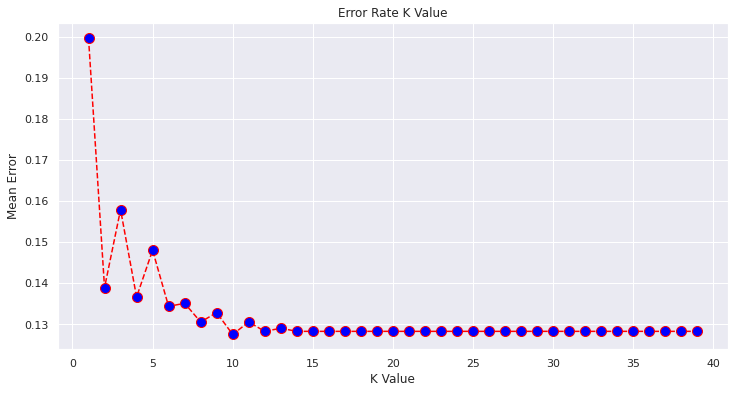

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

## Checking if any of the values correlate

<AxesSubplot:title={'center':'Scatter graph for value of fish'}, xlabel='mean_tonnage', ylabel='value_per_tonne'>

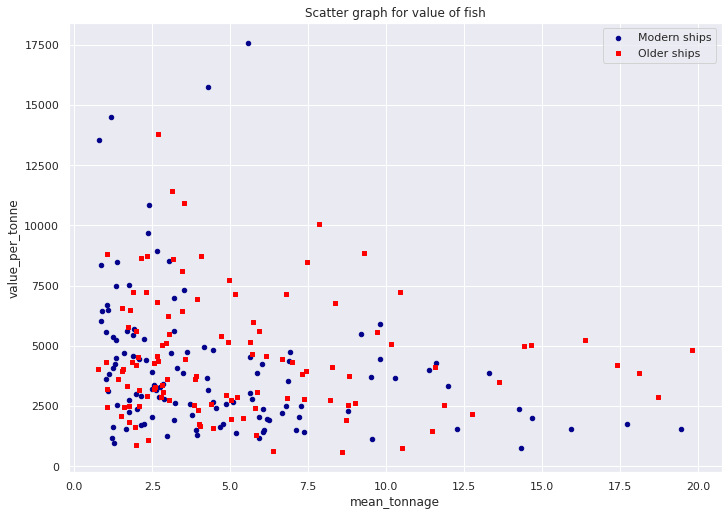

In [79]:
COLUMN_X = 'mean_tonnage'
COLUMN_Y = 'value_per_tonne'

q_low = port_data[COLUMN_X].quantile(0.01)
q_hi  = port_data[COLUMN_X].quantile(0.8)
df_filtered = port_data[(port_data[COLUMN_X] < q_hi) & (port_data[COLUMN_X] > q_low)]

groupA_df = df_filtered[df_filtered['modern_vessel']=='Y']
groupB_df = df_filtered[df_filtered['modern_vessel']=='N']


ax = groupA_df.plot(x=COLUMN_X,
                    y=COLUMN_Y,
                    kind='scatter', color='DarkBlue', label="Modern ships", marker="o",
                    title="Scatter graph for value of fish")

groupB_df.plot(x=COLUMN_X, 
               y=COLUMN_Y,
               kind='scatter', color='Red', label="Older ships", marker='s', ax=ax)


<AxesSubplot:xlabel='Species as shown in publication'>

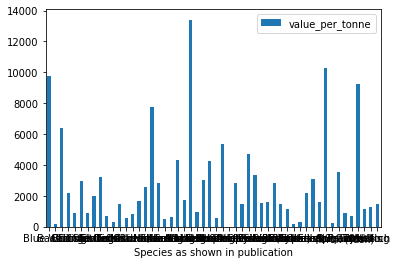

In [26]:
landings_by_species_group.plot.bar(y='value_per_tonne', rot=0)

<AxesSubplot:ylabel='total_weight'>

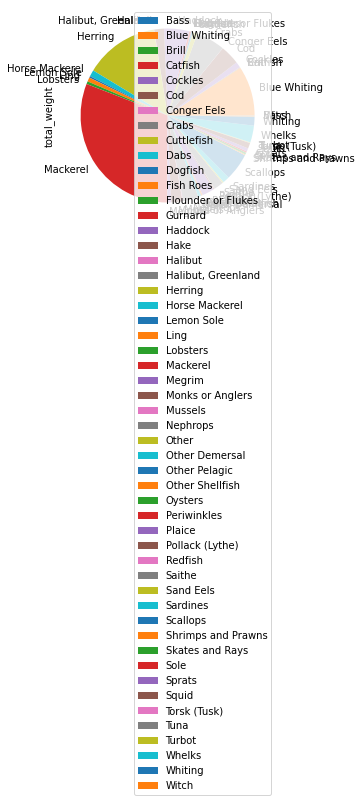

In [27]:
landings_by_species_group.plot(kind='pie', y='total_weight')

In [133]:
landings_df[landings_df['Species as shown in publication'] == 'Lobsters'].groupby('Year').sum()['Value(£)'].mean()

43953673.88300975